# I. PERKENALAN

Nama : Gheddi

Batch : RMT-022

Objective : This project aims to develop ML model to segment credit card customer. The purpose of the project is to offer business a better understanding about their customer to maximize service for different customer segment. To achieve that purpose K-Means model will be implemented and we evaluate its performance using Silhouette Score.

# II. IMPORT LIBRARIES

In [1]:
# essentials
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA, KernelPCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from feature_engine.outliers import Winsorizer

# model
from sklearn.cluster import KMeans


# evaluation
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# model saving
import joblib
import json

# Colab packages
from google.colab import auth
from google.cloud import bigquery
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install feature_engine

In [3]:
auth.authenticate_user()

print('Authenticated')

project_id = "hactiv8-395804" #GUNAKAN GCP PROJECT-ID KALIAN MASING-MASING
client = bigquery.Client(project=project_id)

Authenticated


In [4]:
df = client.query('''
SELECT *
FROM `ftds-hacktiv8-project.phase1_ftds_022_rmt.credit-card-information`
WHERE MOD(CUST_ID,2) = 0;
''').to_dataframe()

In [5]:
df_original = df.copy()

### < Conceptual Problem >

1. INERTIA IS THE MEAN SQUARED DISTANCE BETWEEN EACH DATA POINTS AND ITS CLOSEST CENTROID, IT TELLS US HOW FAR EACH DATAPOINTS TO ITS ASSOCIATED CLUSTER CENTER. Inertia measures how well a dataset was clustered by K-Means. A good model is one with low inertia AND a low number of clusters, because the datapoints within cluster are close together and lower cluster means each cluster are relatively farther to each other.

2. ELBOW METHOD IS A VISUAL AID TO HELP US FIND THE OPTIMAL NUMBER OF CLUSTER FOR K-MEANS. Its plots the wcss or the cost function of K-means for different amount of cluster. In elbow method we look for 'elbow point' where the drop of wcss starts to slow down. Its a subjective method so need to be complemented with silhouette score.

# III. DATA LOADING

# IV. EDA


In [6]:
# displaying the columns inside the dataset and it object type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   Int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   Int64  
 12  PURCHA

1. check if categorical variables exist in the data

after manual checking, its found that there are no categorical variable in the data

In [7]:
df['PURCHASES_FREQUENCY'].unique()

array([0.125   , 0.25    , 0.375   , 0.5     , 0.625   , 0.75    ,
       0.875   , 1.      , 0.090909, 0.181818, 0.363636, 0.142857,
       0.285714, 0.083333, 0.727273, 0.555556, 0.571429, 0.3     ,
       0.6     , 0.333333, 0.454545, 0.666667, 0.916667, 0.909091,
       0.7     , 0.166667, 0.714286, 0.636364, 0.777778, 0.1     ,
       0.2     , 0.4     , 0.8     , 0.583333, 0.833333, 0.428571,
       0.111111, 0.222222, 0.444444, 0.416667, 0.857143, 0.818182,
       0.272727, 0.888889, 0.9     , 0.545455, 0.      ])

In [8]:
df['BALANCE_FREQUENCY'].unique()

array([0.125   , 0.875   , 1.      , 0.375   , 0.545455, 0.454545,
       0.363636, 0.181818, 0.909091, 0.      , 0.272727, 0.090909,
       0.727273, 0.818182, 0.25    , 0.636364, 0.75    , 0.625   ,
       0.6     , 0.5     , 0.833333, 0.444444, 0.666667, 0.8     ,
       0.571429, 0.857143, 0.777778, 0.7     , 0.333333, 0.888889,
       0.166667, 0.714286, 0.2     , 0.3     , 0.1     , 0.9     ,
       0.4     , 0.111111, 0.222222, 0.285714, 0.142857, 0.555556])

In [9]:
df['CASH_ADVANCE_FREQUENCY'].unique()

array([0.      , 0.125   , 0.25    , 0.375   , 0.5     , 0.625   ,
       0.75    , 0.875   , 1.      , 0.090909, 0.181818, 0.363636,
       0.142857, 0.285714, 0.083333, 0.727273, 0.555556, 0.571429,
       0.3     , 0.6     , 0.333333, 0.454545, 0.666667, 0.916667,
       0.909091, 0.166667, 0.714286, 0.636364, 0.777778, 0.1     ,
       0.2     , 0.4     , 0.8     , 0.583333, 0.833333, 0.428571,
       1.166667, 0.111111, 0.222222, 0.444444, 0.416667, 0.857143,
       0.272727, 0.888889, 0.9     , 0.545455])

In [10]:
df['PURCHASES_INSTALLMENTS_FREQUENCY'].unique()

array([0.125   , 0.      , 0.25    , 0.166667, 0.083333, 0.333333,
       0.5     , 0.3     , 0.416667, 0.4     , 0.375   , 0.583333,
       0.666667, 0.75    , 0.625   , 0.875   , 1.      , 0.833333,
       0.7     , 0.916667, 0.857143, 0.909091, 0.888889, 0.9     ,
       0.272727, 0.363636, 0.545455, 0.090909, 0.181818, 0.142857,
       0.636364, 0.727273, 0.555556, 0.571429, 0.285714, 0.714286,
       0.428571, 0.6     , 0.454545, 0.818182, 0.1     , 0.2     ,
       0.111111, 0.444444, 0.222222, 0.777778, 0.8     ])

2. Handling Duplicates

no duplicates found in the data

In [11]:
# checking duplicates
df.duplicated().sum()

0

In [12]:
# drop duplicated row
df.drop_duplicates(inplace = True)

3. Checking the Distribution of each column

no column that are normally distributed

array([[<Axes: title={'center': 'CUST_ID'}>,
        <Axes: title={'center': 'BALANCE'}>,
        <Axes: title={'center': 'BALANCE_FREQUENCY'}>,
        <Axes: title={'center': 'PURCHASES'}>],
       [<Axes: title={'center': 'ONEOFF_PURCHASES'}>,
        <Axes: title={'center': 'INSTALLMENTS_PURCHASES'}>,
        <Axes: title={'center': 'CASH_ADVANCE'}>,
        <Axes: title={'center': 'PURCHASES_FREQUENCY'}>],
       [<Axes: title={'center': 'ONEOFF_PURCHASES_FREQUENCY'}>,
        <Axes: title={'center': 'PURCHASES_INSTALLMENTS_FREQUENCY'}>,
        <Axes: title={'center': 'CASH_ADVANCE_FREQUENCY'}>,
        <Axes: title={'center': 'CASH_ADVANCE_TRX'}>],
       [<Axes: title={'center': 'PURCHASES_TRX'}>,
        <Axes: title={'center': 'CREDIT_LIMIT'}>,
        <Axes: title={'center': 'PAYMENTS'}>,
        <Axes: title={'center': 'MINIMUM_PAYMENTS'}>],
       [<Axes: title={'center': 'PRC_FULL_PAYMENT'}>,
        <Axes: title={'center': 'TENURE'}>, <Axes: >, <Axes: >]],
      dtype=ob

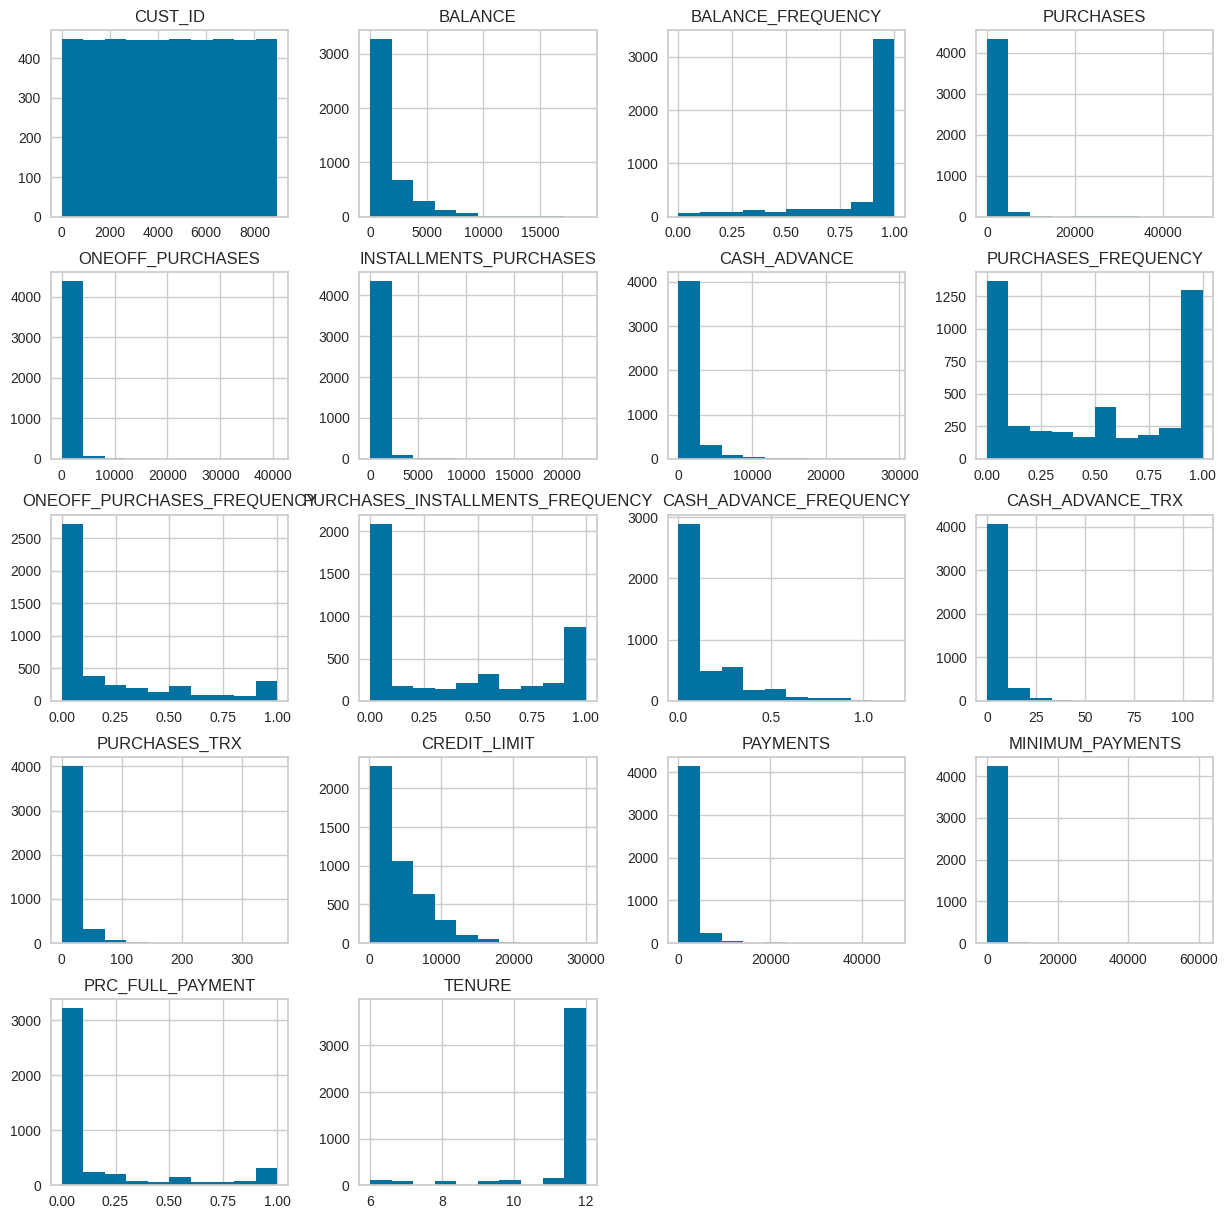

In [13]:
# display the distribution of all column
df.hist(figsize=(15, 15))

4. check correlated variables

the variable that are highly correlated to purchase is oneoff purchases and installment purchase

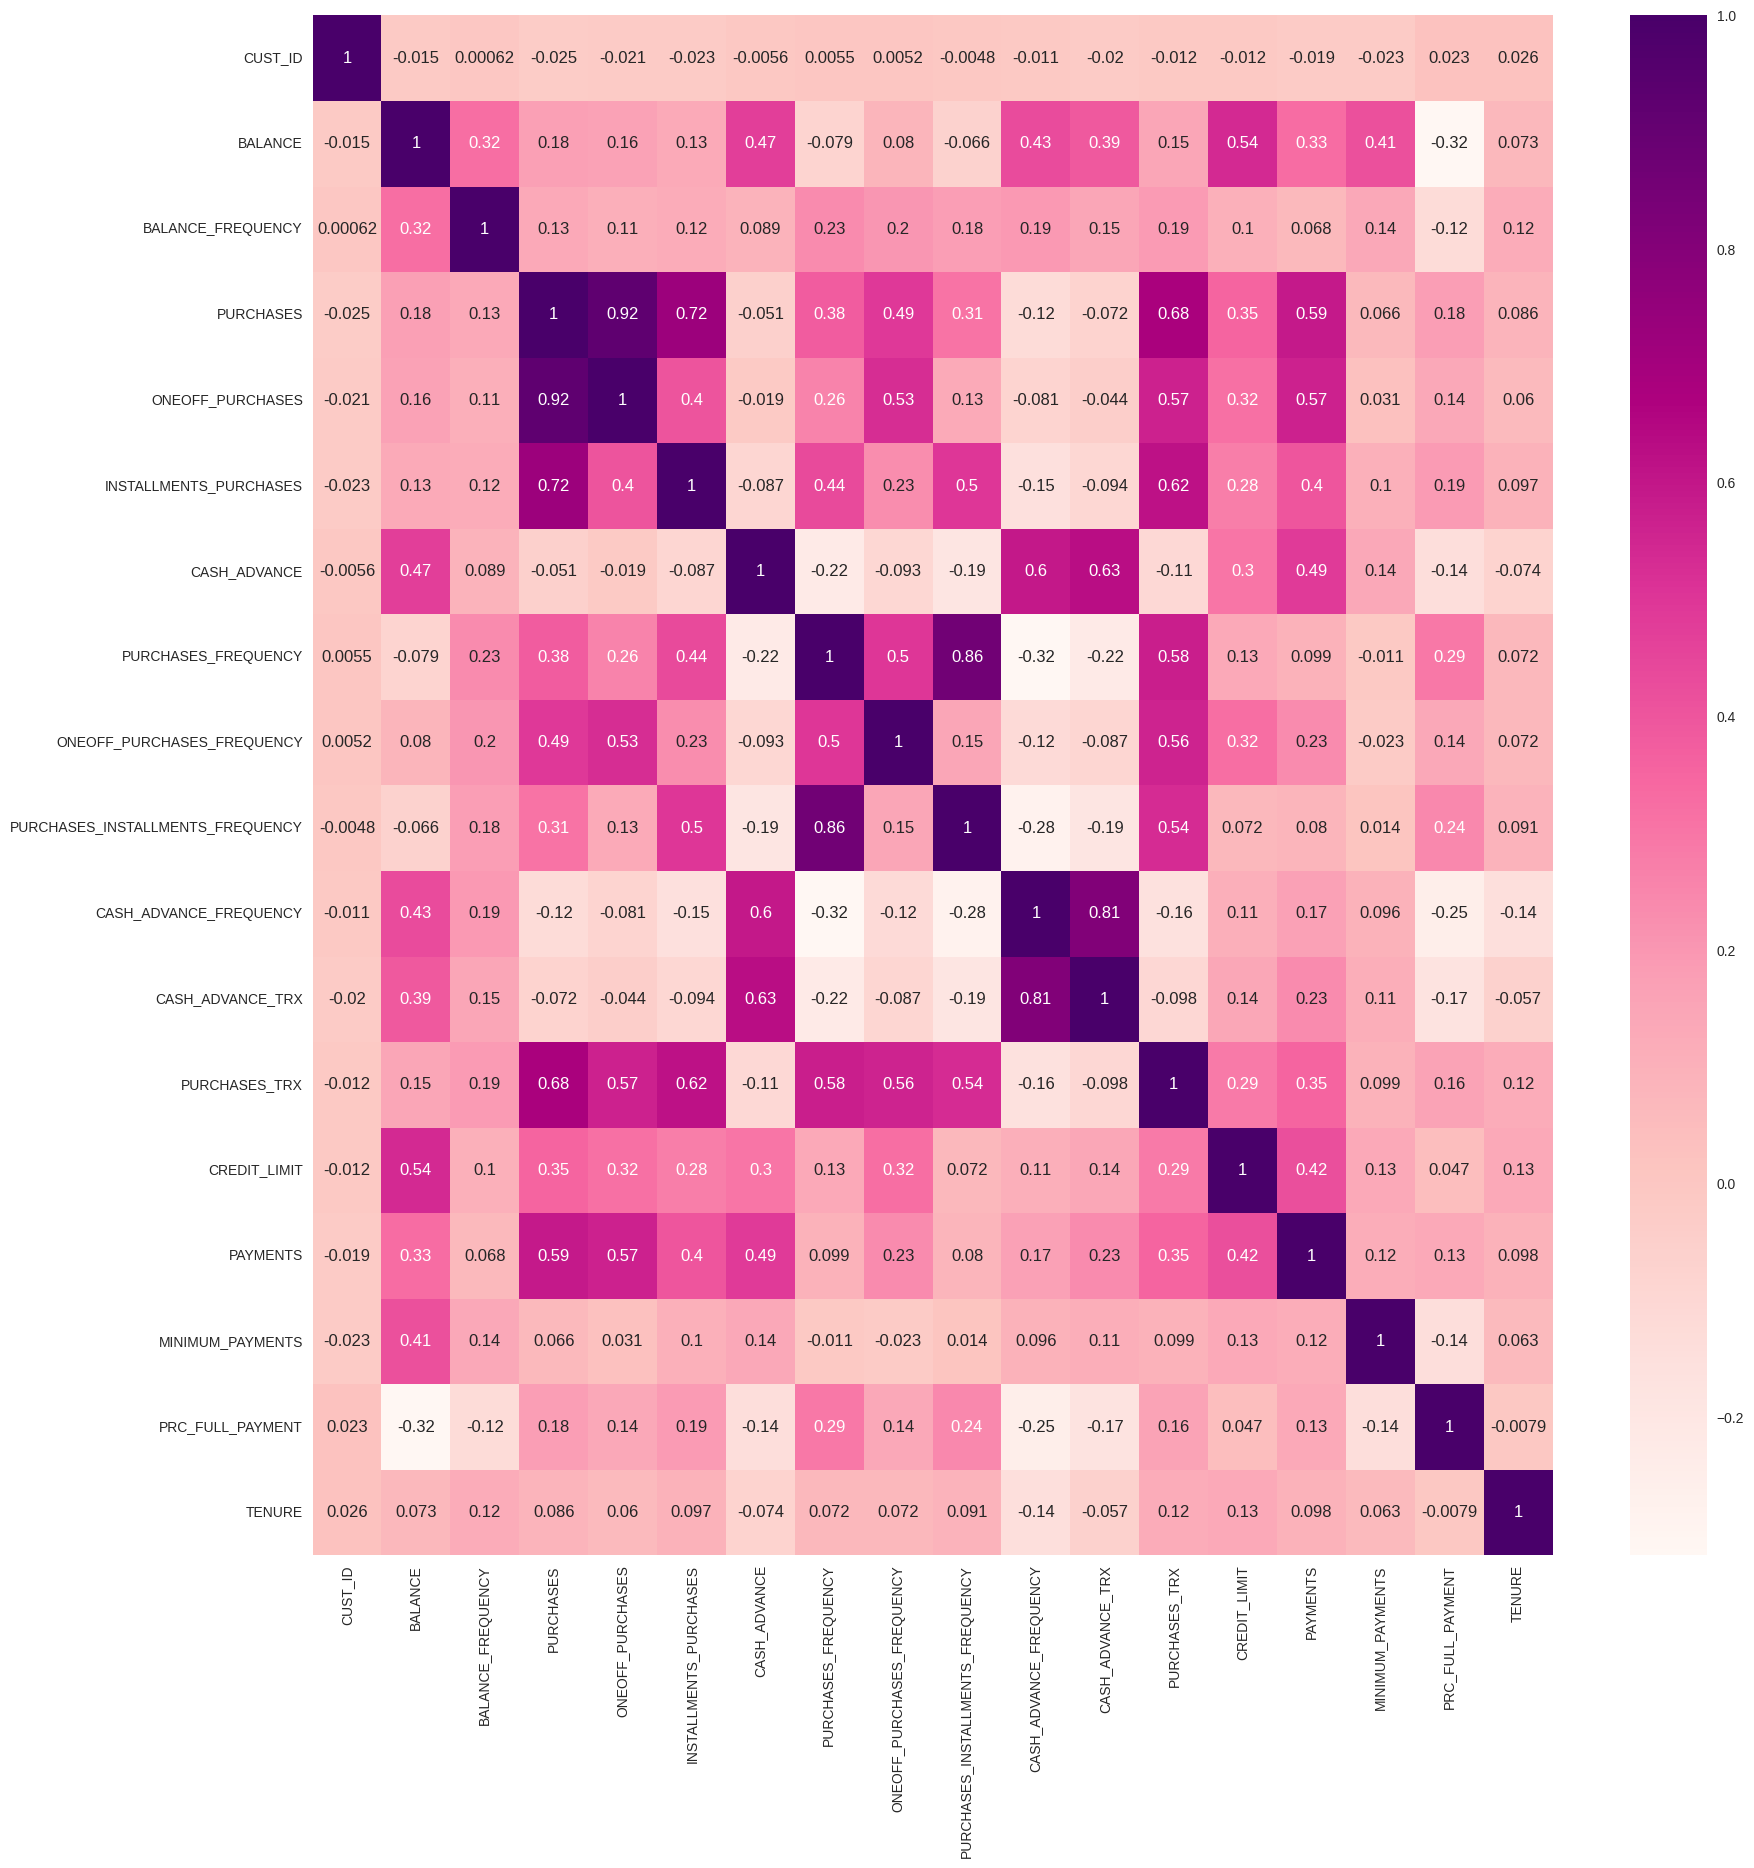

In [14]:
# looking at correllation strength of numerical variable
df_corr=df.corr()

plt.figure(figsize = (20, 20))
sns.heatmap(df_corr,annot=True,cmap='RdPu')
plt.show()

5. Check descriptive statistic of the dataset

no negative values, the biggest numer in the dataset is less than 1 million



In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CUST_ID,4475.0,4476.0,2583.931114,2.0,2239.0,4476.0,6713.0,8950.0
BALANCE,4475.0,1565.743939,2091.205727,0.0,132.536353,874.905296,2058.519163,19043.13856
BALANCE_FREQUENCY,4475.0,0.877608,0.235604,0.0,0.888889,1.0,1.0,1.0
PURCHASES,4475.0,1003.158324,2210.812899,0.0,40.065,362.48,1122.64,49039.57
ONEOFF_PURCHASES,4475.0,588.504849,1666.500287,0.0,0.0,29.99,580.32,40761.25
INSTALLMENTS_PURCHASES,4475.0,415.025075,927.360842,0.0,0.0,89.45,484.255,22500.0
CASH_ADVANCE,4475.0,973.453671,2133.464502,0.0,0.0,0.0,1098.569962,29282.10915
PURCHASES_FREQUENCY,4475.0,0.490122,0.399874,0.0,0.083333,0.5,0.916667,1.0
ONEOFF_PURCHASES_FREQUENCY,4475.0,0.202614,0.298502,0.0,0.0,0.083333,0.333333,1.0
PURCHASES_INSTALLMENTS_FREQUENCY,4475.0,0.364989,0.397336,0.0,0.0,0.166667,0.75,1.0


6. checking missing value

little amount of missing value

In [16]:
df.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    158
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

7. relation between purchases and tenure

from plotting, its found that customer who make bigger purchase are having longer tenure

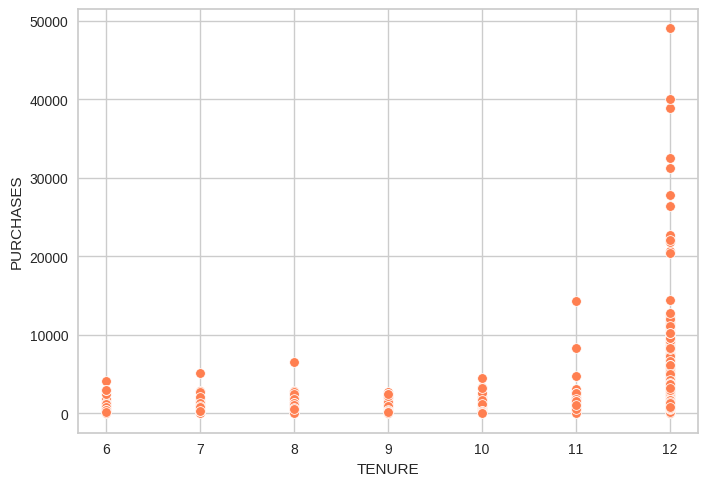

In [17]:
sns.scatterplot(x='TENURE', y='PURCHASES', data=df, color='coral');

8. relation between customer balance and purchases

scatter plot have shown that bigger balance is not a driving factor for customer purchase

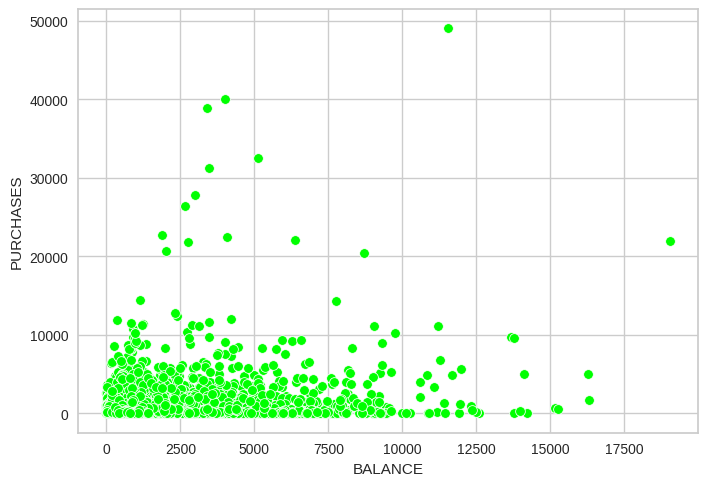

In [18]:
sns.scatterplot(x='BALANCE', y='PURCHASES', data=df,color='lime');

# V. FEATURE ENGINEERING

### < Handling Missing Value >

In [19]:
df.dropna(inplace=True)
df_original.dropna(inplace=True)

### < Filter Out Noise Inducing Feature >

In [20]:
# Customer ID is a noisy feature so we drop it
df.drop('CUST_ID', axis=1, inplace=True)

### < Checking Multicollinearity >

In [21]:
# using VIF score to measure multicollinearity between variable
df_float = df.astype(float)

vif_data = pd.DataFrame()
vif_data["feature"] = df_float.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_float.values, i) for i in range(len(df_float.columns))]

vif_data

,feature,VIF
0,BALANCE,4.131763
1,BALANCE_FREQUENCY,23.447308
2,PURCHASES,63626.666144
3,ONEOFF_PURCHASES,33688.274513
4,INSTALLMENTS_PURCHASES,11158.744951
5,CASH_ADVANCE,3.518476
6,PURCHASES_FREQUENCY,26.587443
7,ONEOFF_PURCHASES_FREQUENCY,5.777873
8,PURCHASES_INSTALLMENTS_FREQUENCY,17.571147
9,CASH_ADVANCE_FREQUENCY,5.226124


### < Feature Selection >

In [22]:
# removing variable with high VIF score
df_float.drop(['BALANCE_FREQUENCY', 'PURCHASES', 'PURCHASES_FREQUENCY','TENURE'], axis=1, inplace=True)

In [23]:
# check VIF score afterwards
vif_data = pd.DataFrame()
vif_data["feature"] = df_float.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_float.values, i) for i in range(len(df_float.columns))]

vif_data

,feature,VIF
0,BALANCE,3.972565
1,ONEOFF_PURCHASES,2.735304
2,INSTALLMENTS_PURCHASES,2.448490
3,CASH_ADVANCE,3.454797
4,ONEOFF_PURCHASES_FREQUENCY,2.631435
5,PURCHASES_INSTALLMENTS_FREQUENCY,2.628973
6,CASH_ADVANCE_FREQUENCY,4.418847
7,CASH_ADVANCE_TRX,4.129580
8,PURCHASES_TRX,4.065081
9,CREDIT_LIMIT,4.087756


### < Handling Outlier >

In [24]:
# using descriptive stats to look for skewed variables
df_float.describe()

,BALANCE,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
count,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000,4316.000000
mean,1600.114511,600.770438,424.888909,986.980658,0.205447,0.369805,0.136236,3.252549,14.801900,4524.431479,1785.801612,854.624165,0.162997
std,2107.347942,1690.105736,940.627467,2159.134558,0.299252,0.398217,0.200511,6.576772,24.473182,3688.856008,2997.093142,2306.642962,0.299700
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,4.841543,0.037744,0.000000
25%,152.877191,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1500.000000,427.905948,169.878606,0.000000
50%,916.693628,35.955000,95.845000,0.000000,0.083333,0.181818,0.000000,0.000000,7.000000,3000.000000,874.442322,309.983200,0.000000
75%,2112.447004,600.000000,498.592500,1110.248526,0.333333,0.750000,0.250000,4.000000,17.000000,6500.000000,1954.888216,830.656813,0.166667
max,19043.138560,40761.250000,22500.000000,29282.109150,1.000000,1.000000,1.166667,110.000000,358.000000,30000.000000,46930.598240,61031.618600,1.000000


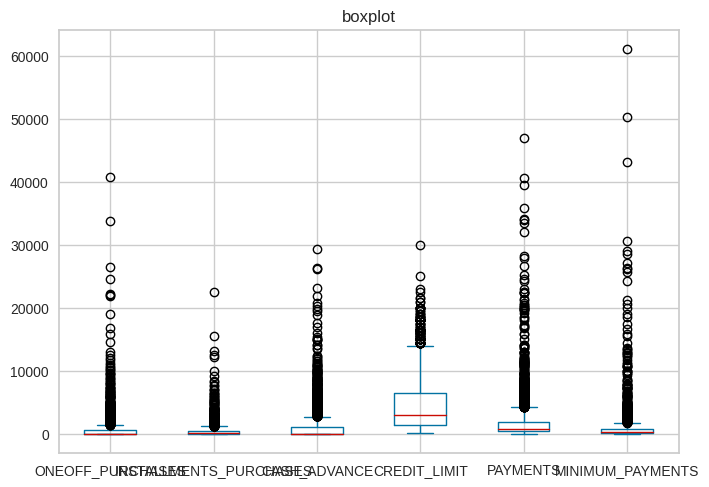

In [25]:
# Checking the outlier
# so many outlier
ax = df_float[['ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS' ,'MINIMUM_PAYMENTS']].plot(kind='box', title='boxplot')
plt.show()

In [26]:
# checking outlier in lower range variable
fig = px.box(df, y="PURCHASES_TRX")
fig.show()

In [27]:
# 8% of values are outlier and the total record in the dataframe is relatively small so we keep it
df_float[df_float['PURCHASES_TRX'] > 41].value_counts().sum()

363

In [28]:
# check outlier on other columns
fig = px.box(df_float, y="MINIMUM_PAYMENTS")
fig.show()

In [29]:
# 8% of data are outlier
df_float[df_float['MINIMUM_PAYMENTS'] > 1821].value_counts().sum()

399

### Capping the data

Because so many columns with extreme outlier, capping method will be used for efficiency and to retain as much information possible

In [30]:
windsoriser = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails
                          fold=1.5,
                          variables=['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
                                     'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
                                     'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
                                     'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT' ])

windsoriser.fit(df_float)

df_float = windsoriser.transform(df_float)

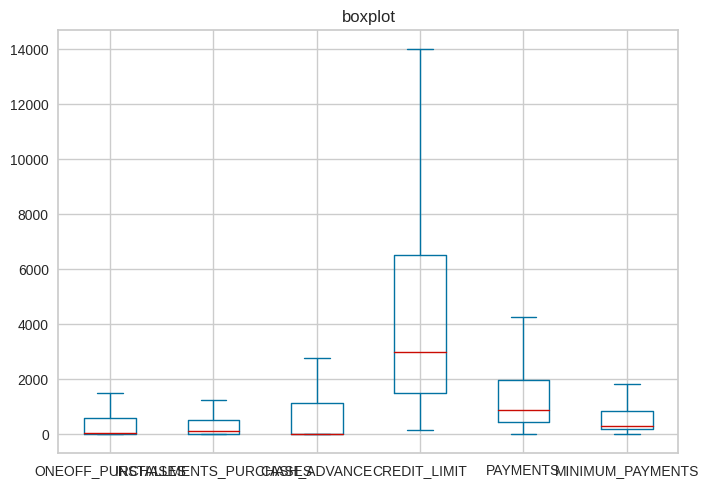

In [31]:
# plotting the box plot after capping
ax = df_float[['ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS' ,'MINIMUM_PAYMENTS']].plot(kind='box', title='boxplot')
plt.show()

### < Normalization >

In [32]:
# Using Robust Scaler because of its versatility
robust_scaler = RobustScaler()
robust_scaler.fit(df_float)
df_scaled = pd.DataFrame(robust_scaler.transform(df_float), columns=df_float.columns)

### < Applying PCA on the data >

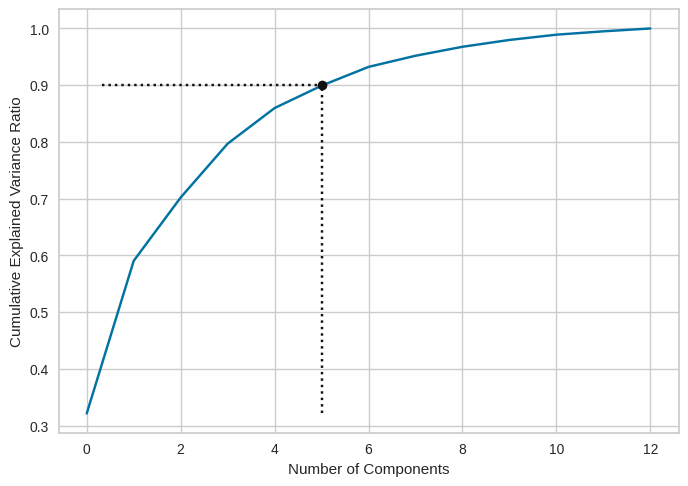

In [33]:
pca_scaled=PCA().fit(df_scaled)
variance_ratio = pca_scaled.explained_variance_ratio_

# Calculate the cumulative sum of the explained variance ratios
cumulative_variance_ratio = np.cumsum(variance_ratio)

# Plot the cumulative explained variance ratio
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.plot([5, 5], [np.cumsum(pca_scaled.explained_variance_ratio_).min(), 0.9], "k:")
plt.plot([np.cumsum(pca_scaled.explained_variance_ratio_).min(), 5], [0.9, 0.9], "k:")
plt.plot(5, 0.9, "ko")
plt.show()

In [34]:
# create PCA object with optimal component
pca = PCA(n_components=5, random_state=42)
# fit PCA to the data
pca.fit(df_scaled)

PCA(n_components=5, random_state=42)

In [35]:
# this is getting only the principal component from PCA
principal_components = ['PC'+str(n) for n in range(1, len(pca.components_)+1)]

# creating a new dataframe with principal components as columns
df_scaled_pca = pd.DataFrame(pca.transform(df_scaled), columns=principal_components)

# VI. MODEL DEFINITION

In [36]:
kmeans = KMeans(random_state=33)

# VII. MODEL TRAINING

### < Finding the optimal cluster with Elbow Method >

elbow point is on the bend where the line started to move straight

In [37]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=33)
    kmeans.fit(df_scaled_pca)
    wcss.append(kmeans.inertia_)

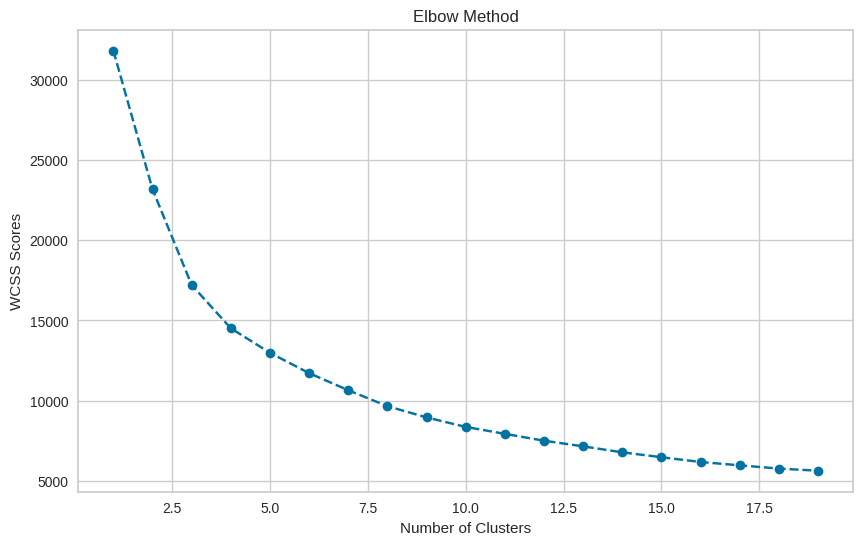

In [38]:
plt.figure(figsize=(10,6))
plt.plot(range(1, 20), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS Scores')
plt.title('Elbow Method')
plt.show()

### < Finding the optimal cluster with Silhouette Score >

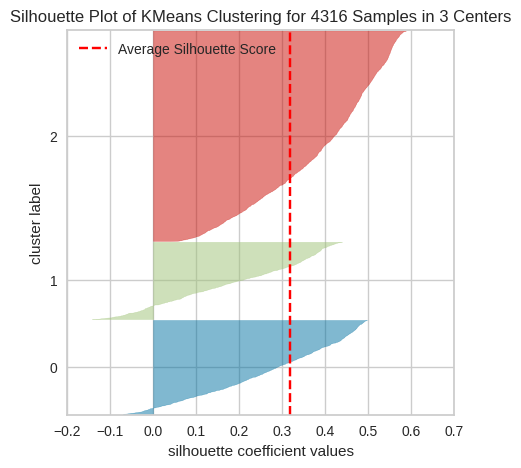

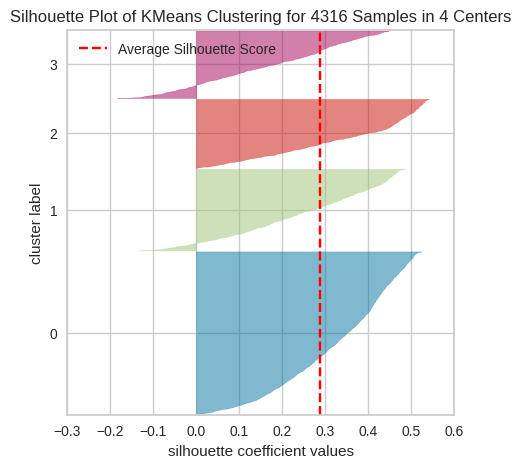

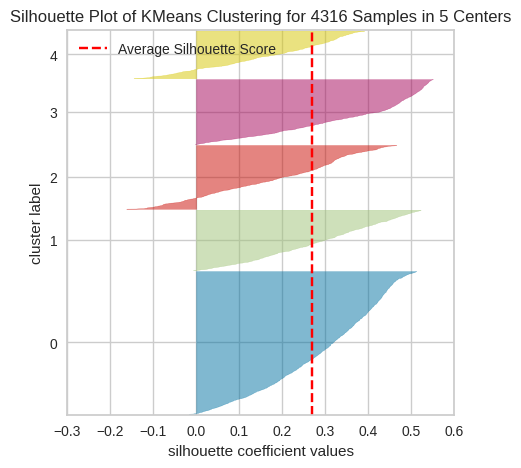

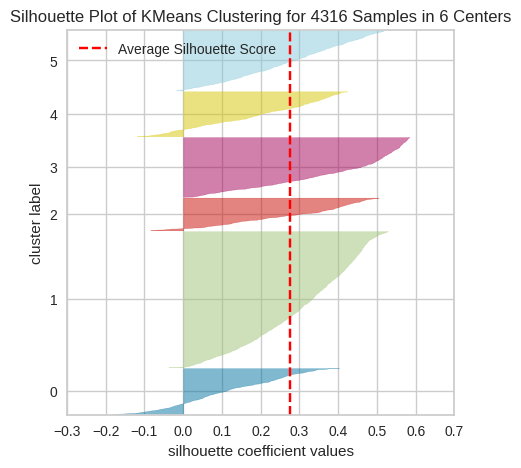

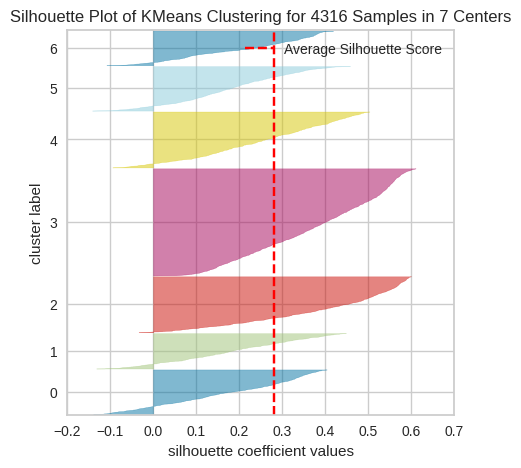

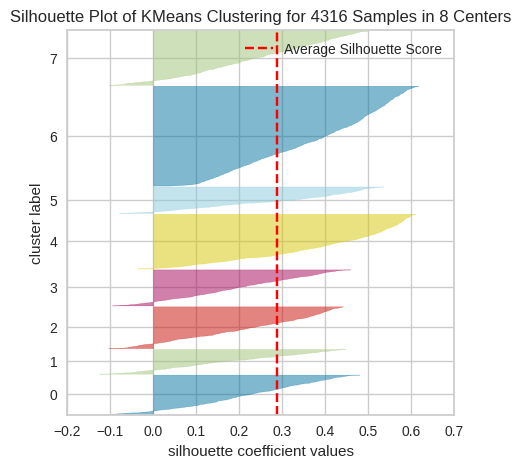

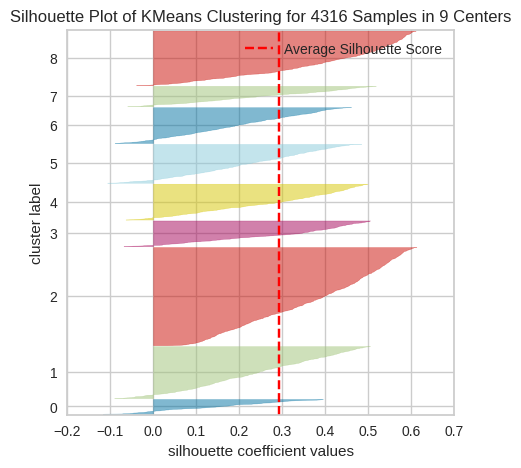

In [39]:
# further inspection to get the optimal number of cluster
for i, n_cluster in enumerate(range(3,10)):

    kmeans = KMeans(n_clusters=n_cluster, random_state=33)

    plt.figure(figsize=(5,5))
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(df_scaled_pca)
    visualizer.show()

In [40]:
# training the model with the optimal cluster
kmeans = KMeans(n_clusters=4, random_state=33)
kmeans.fit(df_scaled_pca)

KMeans(n_clusters=4, random_state=33)

# VIII. MODEL EVALUATION

from model training using elbow method and silhouette score, the optimal value for k. is 4

### < Evaluating K-Means Clustering With Silhouette Score >

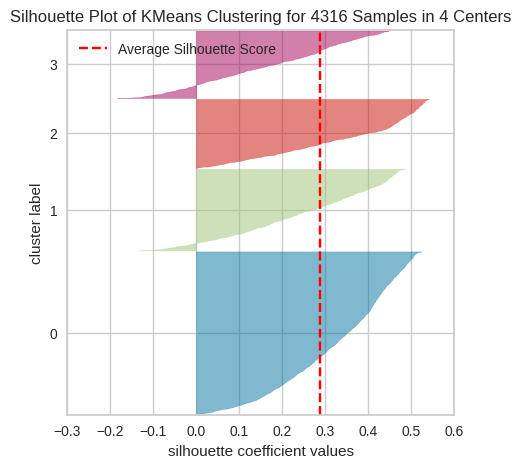

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 4316 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [41]:
plt.figure(figsize=(5,5))
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df_scaled_pca)
visualizer.show()

***Interpreting The Silhouette Score Result***

The silhouette score measure how good each datapoint are assigned in a cluster. The range silhouette score is between -1 and 1 where the higher the number, indicating a better cluster. For example if the silhouette score is 1 then each point are perfectly assigned on each cluster and no overlapping between cluster. If 0 then the cluster are overlapping, and -1 tells us that so many data point assigned to the wrong cluster.

from out silhouette score, each cluster have coefficient score above 0.5 the highest compared to another set of k values. All the cluster exceed the average score of 0.3 signaling all datapoint for each cluster are nicely grouped together. Citing from research gate a coefficient above 0.5 is considered to be good.


https://www.researchgate.net/post/Threshold_silhouette_score_for_cluster_analysis#:~:text=Typically%2C%20a%20silhouette%20score%20of,assigned%20to%20the%20wrong%20cluster.




### < elbow method >



In [42]:
wcss = []
for i in range(2, 8):
    kmeans = KMeans(n_clusters=i, random_state=33)
    kmeans.fit(df_scaled_pca)
    wcss.append(kmeans.inertia_)

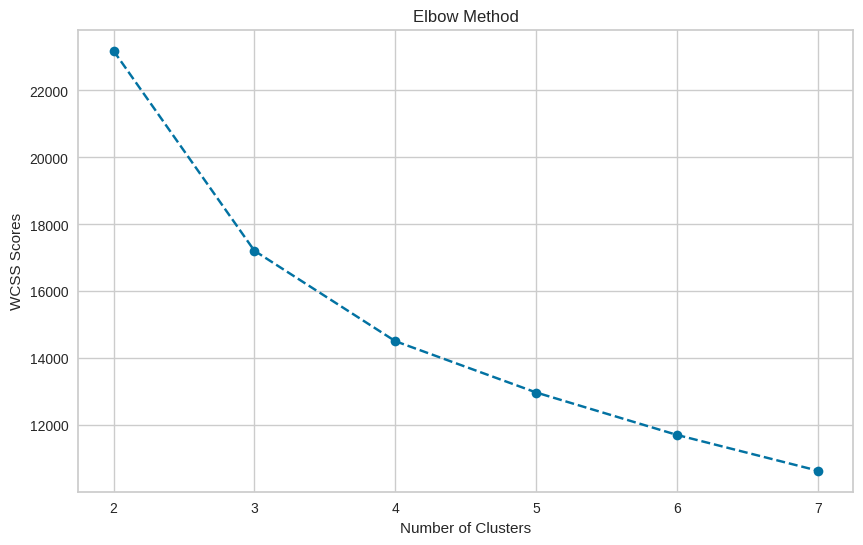

In [43]:
plt.figure(figsize=(10,6))
plt.plot(range(2, 8), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS Scores')
plt.title('Elbow Method')
plt.show()

***Interpreting Elbow Method Result***

From the elbow method we can intepret that optimal k value is 4. From the plot we can see that the elbow point is found at cluster 4, where the wcss score started to drop slower. Further evidence from silhouette score visualization also show that the k-meeans model with 4 cluster is the most optimal model.

from the elbow method we evaluate that our model have the optimal cluster number.

### < Visualize the cluster boundary of the model >

2 dimension cluster visualization

For easier inspection, the 2d plot below shows that the cluster formation is pretty good where only a fraction of datapoint overlapping between cluster.

In [44]:
# create PCA object
pca = PCA(n_components=2, random_state=42)
# fit PCA to the data
pca.fit(df_scaled)

# this is getting only the principal component from PCA
principal_components = ['PC'+str(n) for n in range(1, len(pca.components_)+1)]

# creating a new dataframe with principal components as columns
df_2d_pca = pd.DataFrame(pca.transform(df_scaled), columns=principal_components)
kmeans = KMeans(n_clusters=4, random_state=33)
# using the cluster label from kmeans prediction of the optimal 5 component
df_2d_pca['Cluster'] = kmeans.fit_predict(df_scaled_pca)

<Axes: xlabel='PC1', ylabel='PC2'>

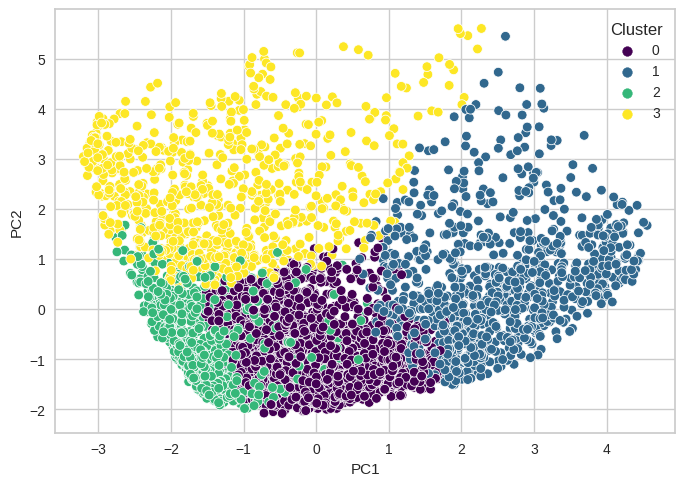

In [45]:
sns.scatterplot(df_2d_pca, x='PC1', y='PC2', hue='Cluster', palette='viridis')

3 dimension cluster visualization

for a more detailed inspection we display 3d plot and it can be seen clearly that the datapoints is more separated compared from 2d plot.

In [46]:
# create PCA object
pca = PCA(n_components=3, random_state=42)
# fit PCA to the data
pca.fit(df_scaled)

# this is getting only the principal component from PCA
principal_components = ['PC'+str(n) for n in range(1, len(pca.components_)+1)]

# creating a new dataframe with principal components as columns
df_3d_pca = pd.DataFrame(pca.transform(df_scaled), columns=principal_components)
kmeans = KMeans(n_clusters=4, random_state=33)
kmeans.fit(df_scaled_pca)
df_3d_pca['Cluster'] = kmeans.predict(df_scaled_pca)

In [47]:
fig = px.scatter_3d(df_3d_pca, x='PC1', y='PC2', z='PC3',
              color='Cluster')
fig.show()

### < Analyzing the characteristic of clusters formed by K-Means >

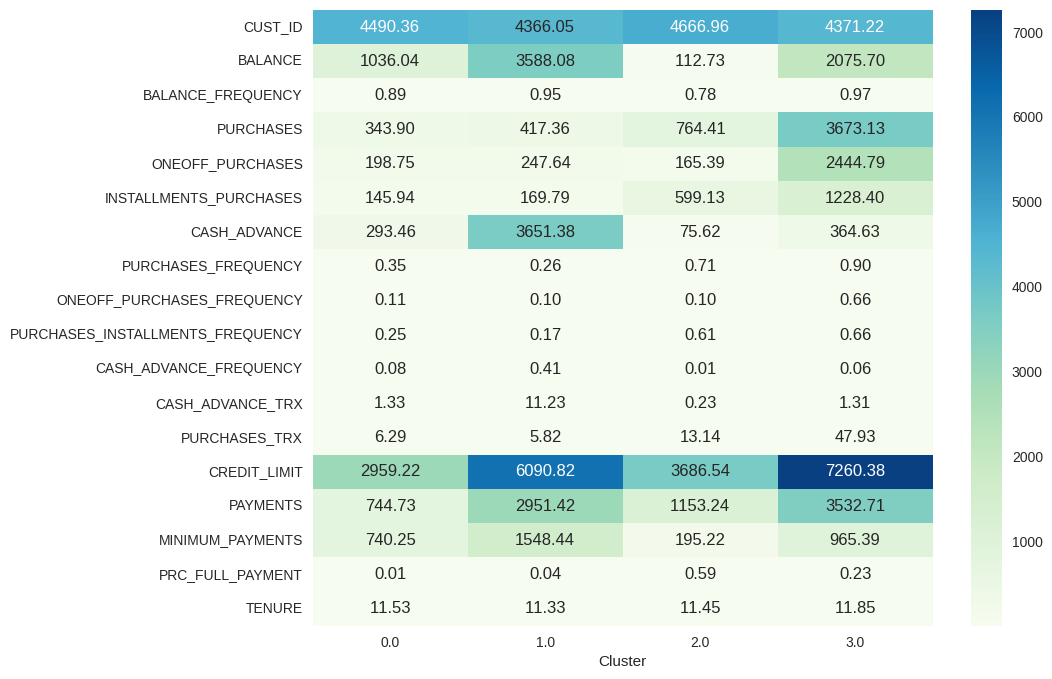

In [48]:
df_original['Cluster'] = kmeans.predict(df_scaled_pca)

df_original['Cluster'] = df_original['Cluster'].astype(float)
df_original['CUST_ID'] = df_original['CUST_ID'].astype(float)
df_original['CASH_ADVANCE_TRX'] = df_original['CASH_ADVANCE_TRX'].astype(float)
df_original['PURCHASES_TRX'] = df_original['PURCHASES_TRX'].astype(float)
df_original['TENURE'] = df_original['TENURE'].astype(float)

clustered_data = df_original.groupby("Cluster").mean()

plt.figure(figsize=(10, 8))
sns.heatmap(clustered_data.T, annot=True,cmap='GnBu', fmt=".2f")
plt.show()

Cluster 0 characteristic : the customer in this group made the least payment from other group. For business consideration it might be better to less prioritize this customer group and utilize the resource towards another group or develop a low cost campaign to increase the intest of this group.

Cluster 1 characteristic : this group has the highest cash advance and balance average but this group is not the top 2 spender among all group. A cashback program may increase their interest to spend more.

Cluster 2 characteristic : this group has the lowest balance among all group, offering top up bonus is plausible to attract them to increase their balance

Cluster 4 characteristic : this group have the highest credit limit and the customer in this grup purchase more than the other group. We need to prioritize this customer by providing vip program to maintain their loyalty

### < Overall Analysis >

1.   After interpreting the result from the Silhouette and Elbow method, its found that our K-Means model is performing well.
2.   The strength of our k-means model is that all the cluster formed have relatively high coefficient exceeding 0.5 threshold from research standard.
3.   For further improvement its better to gather more data before the model can be fully utilized in production environment
4.   Some noteworthy insight from this model analysis are oneoff purchase is highly correlated to purchasing habit of the customer.
5.   suitable business strategy have been explained when determining the associated characteristic of each cluster



# IX. MODEL SAVING

In [49]:
# refitting pca
pca = PCA(n_components=5, random_state=42)
pca.fit(df_scaled)

PCA(n_components=5, random_state=42)

In [50]:
principal_components = ['PC'+str(n) for n in range(1, len(pca.components_)+1)]

In [51]:
model_cols = ['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']

In [52]:
# save model
with open('model_kmeans.pkl', 'wb') as file_1:
  joblib.dump(kmeans, file_1)

with open('model_scaler.pkl', 'wb') as file_2:
  joblib.dump(robust_scaler, file_2)

with open('model_pca.pkl', 'wb') as file_3:
  joblib.dump(pca, file_3)

with open('model_cols.txt', 'w') as file_4:
  json.dump(model_cols, file_4)

with open('model_principal_components.txt', 'w') as file_5:
  json.dump(principal_components, file_5)

# X. MODEL INFERENCE

In [53]:
# loading model
with open('model_kmeans.pkl', 'rb') as file_1:
  model_kmeans= joblib.load(file_1)

with open('model_scaler.pkl', 'rb') as file_2:
  model_scaler= joblib.load(file_2)

with open('model_pca.pkl', 'rb') as file_3:
  model_pca= joblib.load(file_3)

with open('model_cols.txt', 'r') as file_4:
  model_selected_cols= json.load(file_4)

with open('model_principal_components.txt', 'r') as file_5:
  model_principal_components= json.load(file_5)

In [54]:
# making dummmy data for inference
test_data = pd.DataFrame({
  'BALANCE': [1589.141901,],
  'BALANCE_FREQUENCY': [1.0],
  'PURCHASES': [3111.44],
  'ONEOFF_PURCHASES': [1671.09],
  'INSTALLMENTS_PURCHASES': [1440.35],
  'CASH_ADVANCE': [1387.07837],
  'PURCHASES_FREQUENCY': [1.0],
  'ONEOFF_PURCHASES_FREQUENCY': [0.5],
  'PURCHASES_INSTALLMENTS_FREQUENCY': [1.0],
  'CASH_ADVANCE_FREQUENCY': [0.25],
  'CASH_ADVANCE_TRX': [10],
  'PURCHASES_TRX':[50],
  'CREDIT_LIMIT': [3000.0],
  'PAYMENTS': [454.856663],
  'MINIMUM_PAYMENTS': [557.016549],
  'PRC_FULL_PAYMENT': [0.8888],
  'TENURE': [12]
  }
)

In [55]:
test_data = test_data[model_selected_cols]

In [56]:
test_data['CASH_ADVANCE_TRX']=test_data['CASH_ADVANCE_TRX'].astype(float)
test_data['PURCHASES_TRX']=test_data['PURCHASES_TRX'].astype(float)

In [57]:
test_data = pd.DataFrame(model_scaler.transform(test_data), columns = test_data.columns)

In [58]:
# creating a new dataframe with principal components as columns
test_data = pd.DataFrame(model_pca.transform(test_data), columns=model_principal_components)

In [59]:
# making prediction on new data
kmeans.predict(test_data)

array([3], dtype=int32)

# XI. PENGAMBILAN KESIMPULAN

1. the purpose of this project is to implement K-Means to segment credit card user

2. the evaluation of the model using Elbow and Silhouette method have shown that the model is good and applicable in business

2. For business consideration, the performance of our model is considered good and applicable.

3. The strategy that can be implemented forward is to start targeted marketing and offer personalized service for customers in each segment to increase loyalty and retention.

5. for further improvement the author suggest to use more advance clustering mode to compare to the current model.